# Running TCAV


This notebook walks you through things you need to run TCAV. In high level, you need:

1. **example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper**: an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator**: an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model



## Requirements

    pip install the tcav and tensorflow packages (or tensorflow-gpu if using GPU)

In [ ]:
'''
Initial setup
'''
from google.colab import drive
import os
import sys
drive.mount("/content/drive")
os.chdir("/content/drive")

base_drive = 'Shared drives/TCAV4OCT/'
os.chdir(base_drive)

!pwd
%tensorflow_version 1.15.2
try:
  !pip uninstall -y tcav
except:
  print('tcav not installed')
!pip3 install git+https://github.com/schko/tcav.git
!pip3 install matplotlib
# set this to true to run tcav default
default_vars = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/Shared drives/TCAV4OCT
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
  Cloning https://github.com/schko/tcav.git to /tmp/pip-req-build-p91tf_3g
  Running command git clone -q https://github.com/schko/tcav.git /tmp/pip-req-build-p91tf_3g
  Created wheel for tcav: filename=tcav-0.2.1-cp36-none-any.whl size=38543 sha256=c65bfadf183fb923fa82bcc0d46

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

#Step 0. Download images

In [ ]:
def download_images(keywords, limit, path=None):
  from google_images_download import google_images_download   #importing the library

  response = google_images_download.googleimagesdownload()   #class instantiation

  arguments = {"keywords":keywords,"limit":limit,"print_urls":True}   #creating list of arguments
  paths = response.download(arguments)   #passing the arguments to the function
  print(paths)   #printing absolute paths of the downloaded images

# uncomment to download images
#download_images("zebra", limit=100) # this is not working currently for some reason...
#http://www.diddly.com/random/ # random picture finder, # image downloader chrome plugin

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 


You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [ ]:
# folder prefix 
prefix = 'playground'

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
# model_to_run = 'GoogleNet'  
user = 'sharath'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = "/tmp/" + user + '/' + project_name
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live. 
source_dir = prefix + "/image_net_subsets/"
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

if default_vars:
  target = 'zebra'
  bottlenecks = ['mixed4c']  # @param 
else:
  target = 'RNFLprob'
  bottlenecks = ['dense_1']  # @param 
  #bottlenecks = ['mixed_6c']
concepts = ["Glaucoma"]
#concepts = ["dotted","striped","zigzagged"]   


## Step 2. Write your model wrapper

Next step is to tell TCAV how to communicate with your model. See `model.GoolgeNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 1. Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2. Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 3. Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 4. Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! I wrote two model wrapers, InceptionV3 and Googlenet.


**sess**: a tensorflow session.

In [ ]:
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
#
if default_vars:
  GRAPH_PATH =  prefix + "/trained_models/google_net_inception_v1/tensorflow_inception_graph.pb"
  LABEL_PATH = prefix + "/trained_models/google_net_inception_v1/imagenet_comp_graph_label_strings.txt"
  mymodel = model.GoolgeNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH, default_vars)
else:
  # Custom
  #GRAPH_PATH =  prefix + "/trained_models/CNNplusFC/CNNplusFC_model.pb"
  #LABEL_PATH = prefix + "/trained_models/CNNplusFC/CNNplusFC_labelStrings.txt"
  #mymodel = model.CNNFC2NetWrapper_public(sess,
  #                                     GRAPH_PATH,
  #                                     LABEL_PATH, default_vars)
  GRAPH_PATH =  prefix + "/trained_models/multiClassModels/inceptionV3multiClass.pb"
  LABEL_PATH = prefix + "/trained_models/multiClassModels/multiClass_labelStrings.txt"
  mymodel = model.inceptionV3multiClassWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH, default_vars)
# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...






name: "inception_v3/dense_1/BiasAdd"
op: "BiasAdd"
input: "inception_v3/dense_1/MatMul"
input: "inception_v3/dense_1/BiasAdd/ReadVariableOp"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}

name: "inception_v3/dense_2/BiasAdd"
op: "BiasAdd"
input: "inception_v3/dense_2/MatMul"
input: "inception_v3/dense_2/BiasAdd/ReadVariableOp"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}

name: "inception_v3/dense_3/BiasAdd"
op: "BiasAdd"
input: "inception_v3/dense_3/MatMul"
input: "inception_v3/dense_3/BiasAdd/ReadVariableOp"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [ ]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [ ]:
goog=prefix + "/trained_models/multiClassModels/inceptionV3multiClass.pb"
def print_graph_nodes():
  # https://stackoverflow.com/questions/50632258/how-to-restore-tensorflow-model-from-pb-file-in-python
  import tensorflow as tf
  from tensorflow.python.platform import gfile
  GRAPH_PB_PATH = GRAPH_PATH
  with tf.Session() as sess:
    print("load graph")
    with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    print(names)

def load_pb(graphp=GRAPH_PATH):
    with tf.gfile.GFile(graphp, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        return graph

print_graph_nodes()
graph = load_pb(goog)
print(graph.get_operations())
print([n.name for n in graph.as_graph_def().node])
graph = load_pb(GRAPH_PATH)
print(graph.get_operations())
print([n.name for n in graph.as_graph_def().node])

load graph
Instructions for updating:
Use tf.gfile.GFile.
['conv2d_1/kernel', 'batch_normalization_1/beta', 'batch_normalization_1/moving_mean', 'batch_normalization_1/moving_variance', 'keras_learning_phase/input', 'keras_learning_phase', 'conv2d_2/kernel', 'batch_normalization_2/beta', 'batch_normalization_2/moving_mean', 'batch_normalization_2/moving_variance', 'conv2d_3/kernel', 'batch_normalization_3/beta', 'batch_normalization_3/moving_mean', 'batch_normalization_3/moving_variance', 'conv2d_4/kernel', 'batch_normalization_4/beta', 'batch_normalization_4/moving_mean', 'batch_normalization_4/moving_variance', 'conv2d_5/kernel', 'batch_normalization_5/beta', 'batch_normalization_5/moving_mean', 'batch_normalization_5/moving_variance', 'conv2d_9/kernel', 'batch_normalization_9/beta', 'batch_normalization_9/moving_mean', 'batch_normalization_9/moving_variance', 'conv2d_7/kernel', 'conv2d_10/kernel', 'batch_normalization_7/beta', 'batch_normalization_7/moving_mean', 'batch_normalizatio

In [ ]:
import pickle
%matplotlib inline
rc = ['phones', 'bars', 'hands', 'cheetah print', 'money', 'paper clips', 'mri', 'buildings', 'necklace', 'dosa']
tf.logging.set_verbosity(0)
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=10,
                   random_concepts = rc)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)


with open('result.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
print ('done!')


Streaming output truncated to the last 5000 lines.
self.bottlenecks_gradients[bottleneck_name]:  Tensor("gradients/inception_v3/dense_1/Relu_grad/ReluGrad:0", shape=(?, 128), dtype=float32)
bottleneck_name:  dense_1
self.bottlenecks_tensors[bottleneck_name]:  Tensor("inception_v3/dense_1/BiasAdd:0", shape=(?, 128), dtype=float32)
y:  [1]
self.y_input:  Tensor("Placeholder_1:0", shape=(?,), dtype=int64)
----attempting to run session----
grad:  [ 0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0.  0.
 -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0.
 -0.  0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0.  0.  0.  0. -0. -0. -0.
  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.
  0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0.
 -0. -0. -0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.  0. -0. -0.  0.
 -0.  0. -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0.  0. -0.  0. -0.
  0. -0.]
----get_gradient----
self.bottle

In [ ]:
import pickle
results = pickle.load( open( "result.pickle", "rb" ) )

[{'cav_key': 'Glaucoma-phones-dense_1-linear-0.1', 'cav_concept': 'Glaucoma', 'negative_concept': 'phones', 'target_class': 'RNFLprob', 'cav_accuracies': {'Glaucoma': 1.0, 'phones': 0.8181818181818182, 'overall': 0.9090909090909091}, 'i_up': 0.037037037037037035, 'val_directional_dirs_abs_mean': 0.03969319908531412, 'val_directional_dirs_mean': -0.00802017450416458, 'val_directional_dirs_std': 0.15044201582606395, 'val_directional_dirs': [0.0, 0.0, 0.0, 0.0, 0.09210250309237568, 0.0, -1.0527025456825465, 0.0, 0.08842877099520313, 0.0, 0.0, 0.0, 0.0605531708521838, 0.0, 0.0, 0.0, 0.0, 0.06679823713445665, 0.0, 0.0, 0.0, 0.05931520940314199, 0.06002661981196033, 0.0, 0.0, 0.08794694399576874, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015009487475573392, 0.0, 0.07870437311305427, 0.0, 0.0, 0.08827889576518105, -0.2355585412333782, 0.0, 0.0, 0.0, 0.0, 0.05106113920862355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.044870934416385296, 0.0, 0.06207537842712955, 0.0], 'note': 'alpha_0.1 ', 'alpha': 0.1, 'bottlene

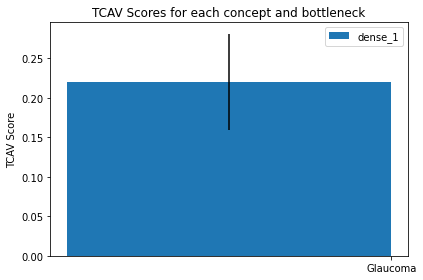

In [ ]:
rc = ['phones', 'bars', 'hands', 'cheetah print', 'money', 'paper clips', 'mri', 'buildings', 'necklace', 'dosa']
print(results)
# our output
utils_plot.plot_results(results, num_random_exp=10, random_concepts=rc)

In [ ]:
utils_plot.plot_results(results, num_random_exp=10)

Class = RNFLprob
  Concept = Glaucoma


KeyError: ignored